In [50]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import lib as lib

# Med p-tables

In [51]:
@njit
def select_price_WoLF(epsilon, price_grid, current_state, policy):
    u = np.random.uniform(0,1)
    if epsilon > u:
        return np.random.choice(price_grid)
    else:
        cumsum = np.cumsum(policy[np.where(price_grid == current_state)[0][0], :])
        idx = np.searchsorted(cumsum, np.array([u]))[0]
        return price_grid[idx]
    

@njit
def Q_func(p_curr, s_curr, s_next, alpha, delta, Q_table, price_grid) -> float: # p_table contains p and s (opponent price)
    """
    args:
        p_curr_idx: current price of player i
        s_curr_idx: current state of player i
        alpha: step-size parameter
        delta: discount factor
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
    returns:
        updated value for Q_table 
    """
    p_curr_idx = np.where(price_grid == p_curr)[0][0]
    s_curr_idx = np.where(price_grid == s_curr)[0][0]
    prev_est = Q_table[p_curr_idx, s_curr_idx]
    s_next_index=np.where(price_grid == s_next)[0][0]
    maxed_Q = max(Q_table[:, s_next_index])
    new_est = lib.profit(p_curr, s_curr) + delta * lib.profit(p_curr, s_next) + delta**2 * maxed_Q
    #new_est = lib.profit(p_table[i, t], p_table[j, t-2]) + delta * lib.profit(p_table[i, t], s_next) + delta**2 * maxed_Q
    return (1 - alpha) * prev_est + alpha * new_est

@njit
def select_price_Q(epsilon, price_grid, current_state, Q_table):
    """
    args:
        j: player 1
        t: current period
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table
        price_grid: price_grid
        epsilon: decay parameter of learning module
    returns:
        random price or maximized price
    """
    # Exploration
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(price_grid)
    else:
    # Exploitation
        s_t_idx = np.where(price_grid == current_state)[0][0] # current state (opponent's price)
        maxedQ_idx = np.argmax(Q_table[:,s_t_idx])
        return price_grid[maxedQ_idx]
    

In [52]:
@njit
def WoLF_PHC_vs_Q_learner2(alpha, delta_w, delta_l, gamma, price_grid, T):
    """
    args:
        alpha: step-size parameter
        delta_w: learnig rate when winning
        pdelta_l: learning rate when losing
        gamma: discount factor
        price_grid: vector containing all prices. 
        T: learning duration
    returns:
        q1: Q-table player 1
        q2: Q-table player 2
        avg_profs1: vecotr of average profits for player 1
        avg_profs2: vector of average profits for player 2
        profits: 2x500.000 array containing all profits
        p_table: 2x500.000 array conatining all prices played
    """
    # Initializing values
    epsilon = lib.calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    k = len(price_grid)
    q1 = np.zeros((k, k))
    q2 = np.zeros((k, k))
    # Initializing policies
    policy_1 = np.ones((k, k)) / k
    # Initializing average policies
    avg_policy1 = np.ones((k, k)) / k
    # Initializing N, a counter
    N1 = np.zeros(k)
    # Initializing profits
    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []

    # Setting random price and state for t = 0
    p_table[i, t] = np.random.choice(price_grid) #p_Q = np.random.choice(price_grid) 
    p_table[j, t] = np.random.choice(price_grid) #p_WoLF = np.random.choice(price_grid) 
    
    t += 1
    # Setting random price and state for t = 1
    p_table[i, t] = np.random.choice(price_grid) #s_Q = np.random.choice(price_grid) 
    p_table[j, t] = np.random.choice(price_grid) #s_WoLF = np.random.choice(price_grid) 
    t += 1
    method = 'WoLF-PHC'
    for t in range(t, T-1):
        if method == 'WoLF-PHC':
            p_table[i, t] = p_table[i, t-1]
            profit_now = lib.profit(p_table[i,t], p_table[j,t-1]) 
            profit_next = lib.profit(p_table[i,t], p_table[j,t]) 
            r_t = profit_now + gamma * profit_next
            p_idx = np.where(price_grid == p_table[i,t])[0][0]
            s_curr_idx = np.where(price_grid == p_table[j,t-1])[0][0]
            s_next_idx = np.where(price_grid == p_table[j, t])[0][0]
            
            max_Q = max(q1[s_next_idx, :])
            q1[s_curr_idx, p_idx] = q1[s_curr_idx, p_idx] + alpha * (r_t + gamma**2 *max_Q - q1[s_curr_idx, p_idx])
            N1[s_curr_idx] += 1

            avg_policy1[s_curr_idx, :] = avg_policy1[s_curr_idx, :] + (1 / N1[s_curr_idx]) * (policy_1[s_curr_idx, :] - avg_policy1[s_curr_idx, :])
            avg_policy1[s_curr_idx, :] /= avg_policy1[s_curr_idx, :].sum() # To ensure a legal probability distribution
            if np.sum(q1[s_curr_idx, :] * policy_1[s_curr_idx, :]) > np.sum(q1[s_curr_idx, :] * avg_policy1[s_curr_idx, :]):
                delta = delta_w
            else:
                delta = delta_l 

            delta_sa = np.zeros(k) - delta / (k - 1)
            p_max_idx = np.argmax(q1[s_curr_idx, :])
            delta_sa[p_max_idx] = - (delta_sa.sum() - delta_sa[p_max_idx])
            policy_1[s_curr_idx, :] += delta_sa
            policy_1[s_curr_idx, :] = np.minimum(1, np.maximum(policy_1[s_curr_idx, :], 0))
            policy_1[s_curr_idx, :] /= policy_1[s_curr_idx, :].sum() # To ensure a legal probability distribution
            p_table[i,t+1] = select_price_WoLF(epsilon[t], price_grid, p_table[j,t], policy_1)
            p_table[j,t+1] = p_table[j,t]
            profits[i, t] = profit_now #profit(p_Q, p_WoLF)
            profits[j, t] = lib.profit(p_table[j,t], p_table[i,t])

            i,j = j,i
            method = 'Q-learner'
        else:
            p_table[i, t] = p_table[i, t-1]
            profit_now = lib.profit(p_table[i,t], p_table[j,t-1])
            profit_next = lib.profit(p_table[i,t], p_table[j,t])
            r_t = profit_now + gamma * profit_next
            p_table[i,t+1] = select_price_Q(epsilon[t], price_grid, p_table[j,t], q2)
            q2[s_curr_idx, p_idx] = Q_func(p_table[i,t], p_table[j,t-1], p_table[j,t], alpha, gamma, q2, price_grid)
            p_table[j,t+1] = p_table[j,t]
            profits[i, t] = profit_now
            profits[j, t] = lib.profit(p_table[j,t], p_table[i,t])
            i,j = j,i
            method = 'WoLF-PHC'
         # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[0, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[1, (t-1000):t])/1000
            avg_profs2.append(profitability)

           
    return q1, q2, avg_profs1, avg_profs2, profits, p_table

            



In [65]:
q1, q2, avg_prof1, avg_prof2, profit, p_table = WoLF_PHC_vs_Q_learner2(0.3, 0.2, 0.6, 0.95, np.linspace(0,1,7), 500000)

In [66]:
p_table[:, 499920:499950]

array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        1.        , 1.        , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 1.        , 1.        ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 1.        , 1.        , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 1.        ],
       [0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.16666667,
        0.16666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.16666667, 0.16666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.16666667, 0.16666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.16666667, 0.16666667]])

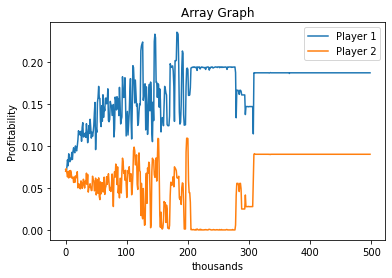

In [67]:
x_values = range(len(avg_prof1))

# Plot the array as a line graph
plt.plot(x_values, avg_prof1)
plt.plot(x_values, avg_prof2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()